In [1]:
import pandas as pd

# --- Load reference map ---
map_path = "cell_sanger_map.csv"
df_map = pd.read_csv(map_path)
sidm_to_name = dict(zip(df_map["SANGER_MODEL_ID"], df_map["CELL_LINE_NAME"]))

# --- Load breast (column = 'SIDM') ---
breast = pd.read_csv("breast_cancer_cell_lines.csv")
print("Breast columns:", breast.columns)

breast_norm = breast.copy()
breast_norm["CELL_LINE_NAME"] = breast_norm["SIDM"].map(sidm_to_name).fillna(breast_norm["SIDM"])

# --- Load pancancer (column = 'cell_line') ---
pancancer = pd.read_csv("pancancer_cell_lines.csv")
print("Pancancer columns:", pancancer.columns)

pancancer_norm = pancancer.copy()
pancancer_norm["CELL_LINE_NAME"] = pancancer_norm["cell_line"].map(sidm_to_name).fillna(pancancer_norm["cell_line"])

# Load Tahoe reference
tahoe = pd.read_csv("tahoe_cell_lines_50.csv")

# Use the proper column 'Cell_Name' (capitalized)
tahoe_norm = tahoe.rename(columns={"Cell_Name": "CELL_LINE_NAME"})

# Save corrected normalized file
tahoe_norm.to_csv("tahoe_cell_lines_normalized.csv", index=False)

print("Corrected Tahoe normalized file with CELL_LINE_NAME column.")
print(tahoe_norm.head())


Breast columns: Index(['SIDM'], dtype='object')
Pancancer columns: Index(['cell_line'], dtype='object')
Corrected Tahoe normalized file with CELL_LINE_NAME column.
  CELL_LINE_NAME   DepMap_ID Cellosaurus_ID   Organ
0           A549  ACH-000681      CVCL_0023    Lung
1       COLO 205  ACH-001039      CVCL_0218   Bowel
2          HT-29  ACH-000552      CVCL_0320   Bowel
3          SW480  ACH-000842      CVCL_0546   Bowel
4        HS-578T  ACH-000148      CVCL_0332  Breast


In [2]:
# Load all normalized
breast_norm = pd.read_csv("breast_cell_lines_normalized.csv")
pancancer_norm = pd.read_csv("pancancer_cell_lines_normalized.csv")
tahoe_norm = pd.read_csv("tahoe_cell_lines_normalized.csv")

# Convert to sets
breast_set = set(breast_norm["CELL_LINE_NAME"].dropna().unique())
pancancer_set = set(pancancer_norm["CELL_LINE_NAME"].dropna().unique())
tahoe_set = set(tahoe_norm["CELL_LINE_NAME"].dropna().unique())

print("Breast lines:", len(breast_set))
print("Pan-cancer lines:", len(pancancer_set))
print("Tahoe lines:", len(tahoe_set))

print("\nPairwise overlaps:")
print("Breast ∩ Pan-cancer:", breast_set & pancancer_set)
print("Breast ∩ Tahoe:", breast_set & tahoe_set)
print("Pan-cancer ∩ Tahoe:", pancancer_set & tahoe_set)

print("\nTriple overlap (all 3):", breast_set & pancancer_set & tahoe_set)


Breast lines: 28
Pan-cancer lines: 140
Tahoe lines: 50

Pairwise overlaps:
Breast ∩ Pan-cancer: {'MDA-MB-436', 'BT-474', 'MDA-MB-361', 'HCC38', 'T47D', 'HDQ-P1', 'CAMA-1', 'MCF7', 'BT-549'}
Breast ∩ Tahoe: {'BT-474'}
Pan-cancer ∩ Tahoe: {'AsPC-1', 'C32', 'BT-474', 'NCI-H460', 'NCI-H2347', 'NCI-H1792', 'SNU-423', 'SK-MEL-2'}

Triple overlap (all 3): {'BT-474'}


In [3]:
import pandas as pd

# Load normalized reference files
breast = pd.read_csv("breast_cell_lines_normalized.csv")
pancancer = pd.read_csv("pancancer_cell_lines_normalized.csv")
tahoe = pd.read_csv("tahoe_cell_lines_normalized.csv")

# Turn into sets
breast_set = set(breast["CELL_LINE_NAME"].dropna().unique())
pancancer_set = set(pancancer["CELL_LINE_NAME"].dropna().unique())
tahoe_set = set(tahoe["CELL_LINE_NAME"].dropna().unique())

# Union of all lines
all_lines = sorted(breast_set | pancancer_set | tahoe_set)

# Presence table
rows = []
for line in all_lines:
    rows.append({
        "CELL_LINE_NAME": line,
        "Present_in_Breast": int(line in breast_set),
        "Present_in_PanCancer": int(line in pancancer_set),
        "Present_in_Tahoe": int(line in tahoe_set),
    })
overlap_df = pd.DataFrame(rows)

print("Overlap table shape:", overlap_df.shape)
display(overlap_df.head(12))

# Save
overlap_df.to_csv("cell_line_overlap_table.csv", index=False)
print("Saved: cell_line_overlap_table.csv")


Overlap table shape: (201, 4)


,CELL_LINE_NAME,Present_in_Breast,Present_in_PanCancer,Present_in_Tahoe
0,23132-87,0,1,0
1,42-MG-BA,0,1,0
2,8305C,0,1,0
3,A-172,0,0,1
4,A-427,0,0,1
5,A204,0,1,0
6,A2058,0,1,0
7,A375,0,1,0
8,A498,0,0,1
9,A549,0,0,1


Saved: cell_line_overlap_table.csv


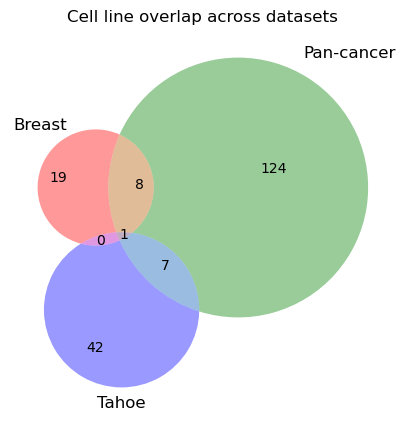

In [4]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
venn3(
    subsets=(len(breast_set - pancancer_set - tahoe_set),
             len(pancancer_set - breast_set - tahoe_set),
             len(breast_set & pancancer_set - tahoe_set),
             len(tahoe_set - breast_set - pancancer_set),
             len(breast_set & tahoe_set - pancancer_set),
             len(pancancer_set & tahoe_set - breast_set),
             len(breast_set & pancancer_set & tahoe_set)),
    set_labels=("Breast", "Pan-cancer", "Tahoe")
)
plt.title("Cell line overlap across datasets")
plt.show()


In [5]:
# Example: merge Tahoe organ annotations
if "Organ" in tahoe.columns:
    overlap_df = overlap_df.merge(
        tahoe[["CELL_LINE_NAME","Organ"]].drop_duplicates(),
        on="CELL_LINE_NAME", how="left"
    )

tissue_counts = (overlap_df.groupby("Organ")[["Present_in_Breast","Present_in_PanCancer","Present_in_Tahoe"]]
                 .sum().sort_values("Present_in_Tahoe", ascending=False))
display(tissue_counts.head(10))


,Present_in_Breast,Present_in_PanCancer,Present_in_Tahoe
Organ,,,
Lung,0,3,15
Bowel,0,0,9
Pancreas,0,1,7
Skin,0,2,4
CNS/Brain,0,0,3
Uterus,0,0,2
Liver,0,1,2
Breast,1,1,2
Esophagus/Stomach,0,0,2
